<a href="https://colab.research.google.com/github/SithmiDesilva/OralCancerEarlyDetection-DSGP/blob/Prediction-of-textual-data-II/Fusion_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import the libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **1. Load the Dataset**

In [ ]:
data_path = "/content/drive/MyDrive/DSGP/Model_Fusion/meta_model_dataset.csv"
data = pd.read_csv(data_path)

###**2. Exploratory Data Analysis**

In [ ]:
print("\nSample Data:")
print(data.head())


Sample Data:
  Patient_ID  Text_Pred  Image_Pred Final_Risk
0      P0001       0.37        0.70   Moderate
1      P0002       0.95        0.54   Moderate
2      P0003       0.73        0.31   Moderate
3      P0004       0.60        0.81   Moderate
4      P0005       0.16        0.68   Moderate


In [ ]:
#Identify data types
print("Identifying types of information:"'\n')
data.info()

Identifying types of information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Patient_ID  500 non-null    object 
 1   Text_Pred   500 non-null    float64
 2   Image_Pred  500 non-null    float64
 3   Final_Risk  500 non-null    object 
dtypes: float64(2), object(2)
memory usage: 15.8+ KB


In [ ]:
#No. of rows and columns in the dataset
data.shape

(500, 4)

In [ ]:
#Descriptive statistics of the dataset
data.describe()

,Text_Pred,Image_Pred
count,500.000000,500.000000
mean,0.498720,0.481920
std,0.298756,0.285491
min,0.010000,0.000000
25%,0.240000,0.230000
50%,0.510000,0.470000
75%,0.760000,0.730000
max,0.990000,1.000000


In [ ]:
#Identifying missing values
data.isnull().sum()

,0
Patient_ID,0
Text_Pred,0
Image_Pred,0
Final_Risk,0


In [ ]:
#Identifying duplicated values
data.duplicated().sum()

np.int64(0)

### **3. Feature Engineering**

In [ ]:
#Drop unwanted features
if 'Patient_ID' in data.columns:
    data = data.drop('Patient_ID', axis=1)

print(data.head())

   Text_Pred  Image_Pred Final_Risk
0       0.37        0.70   Moderate
1       0.95        0.54   Moderate
2       0.73        0.31   Moderate
3       0.60        0.81   Moderate
4       0.16        0.68   Moderate


In [ ]:
#Identifying available columns
print("\nColumns in the dataset:" '\n')
print(data.columns)



Columns in the dataset:

Index(['Text_Pred', 'Image_Pred', 'Final_Risk'], dtype='object')


### **4. Handle Class Imbalance**

In [ ]:
#Check the availability of class imbalance
data['Final_Risk'].value_counts()

,count
Final_Risk,
Moderate,380
Low,96
High,24


In [ ]:
#Apply SMOTE to handle class imbalance
X = data.drop('Final_Risk', axis=1)
y = data['Final_Risk']

# Initialize SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new balanced DataFrame
balanced_data = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Final_Risk'])], axis=1)



In [ ]:
#Understand the balanced data
balanced_data['Final_Risk'].value_counts()

,count
Final_Risk,
Moderate,380
Low,380
High,380


In [ ]:
#No. of rows and columns of the balanced dataset
balanced_data.shape

(1140, 3)

In [ ]:
#Renamed X and y after SMOTE resampling
X_resampled = balanced_data[['Text_Pred', 'Image_Pred']]
y_resampled = balanced_data['Final_Risk']

print('Features:''\n',X)
print('Target:''\n',y)

Features:
      Text_Pred  Image_Pred
0         0.37        0.70
1         0.95        0.54
2         0.73        0.31
3         0.60        0.81
4         0.16        0.68
..         ...         ...
495       0.35        0.09
496       0.58        0.92
497       0.08        0.14
498       0.97        0.95
499       0.99        0.45

[500 rows x 2 columns]
Target:
 0      Moderate
1      Moderate
2      Moderate
3      Moderate
4      Moderate
         ...   
495         Low
496    Moderate
497         Low
498        High
499    Moderate
Name: Final_Risk, Length: 500, dtype: object


In [ ]:
#Encode Risk Labels
label_encoder = LabelEncoder()
y_resampled_encoded = label_encoder.fit_transform(y_resampled)

print("\nEncoded Classes:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Encoded Classes: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}


In [ ]:
#Split train and test data

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_encoded, test_size=0.3, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(798, 2)
(342, 2)
(798,)
(342,)


### **5. Model Training**

In [ ]:
# Training Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
#Perform cross validation
cv_scores = cross_val_score(model, X, y, cv=5)
print(f"Cross-validation scores: {cv_scores}")


Cross-validation scores: [0.99 1.   1.   0.98 1.  ]


In [ ]:
#Perform Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Score: 0.9962421383647799


### **6. Model Evaluation**

In [ ]:
#Generate classification report
y_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))




Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       122
         Low       1.00      0.99      0.99        96
    Moderate       0.99      1.00      1.00       124

    accuracy                           1.00       342
   macro avg       1.00      1.00      1.00       342
weighted avg       1.00      1.00      1.00       342



In [ ]:
#Feature importance
feature_importances = pd.Series(model.feature_importances_, index=X_resampled.columns).sort_values(ascending=False)
print(feature_importances)


Image_Pred    0.520511
Text_Pred     0.479489
dtype: float64


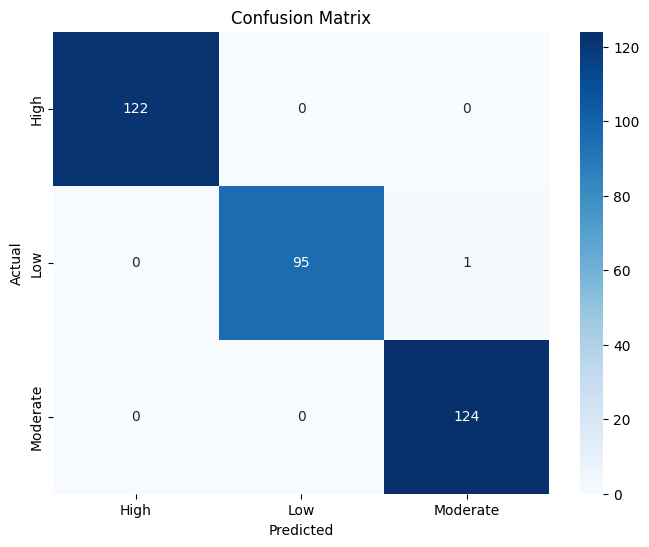

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Evaluate on training data
train_accuracy = model.score(X_train, y_train)

# Evaluate on test data
test_accuracy = model.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")


Training Accuracy: 1.0
Testing Accuracy: 0.9970760233918129


### **7. Save the model and label encoded files**

In [ ]:
# Save the model and label encoder in the drive
save_path = '/content/drive/MyDrive/DSGP/Model_Fusion'

joblib.dump(model, save_path + "oncooral_meta_model.pkl")
joblib.dump(label_encoder, save_path + "oncooral_label_encoder.pkl")

print("\n Meta-model and Label Encoder saved successfully to Google Drive!")


 Meta-model and Label Encoder saved successfully to Google Drive!


### **8. Predictive System**

In [ ]:
#Load Model & Label Encoder

model = joblib.load("oncooral_meta_model.pkl")
label_encoder = joblib.load("oncooral_label_encoder.pkl")

print("  OncoOral AI Meta-Model Loaded!")

#Get User Inputs

try:
    text_pred = float(input("\nEnter Text Model Prediction (0 to 1): "))
    image_pred = float(input("Enter Image Model Prediction (0 to 1): "))

    if not (0 <= text_pred <= 1 and 0 <= image_pred <= 1):
        raise ValueError("Predictions must be between 0 and 1.")

#Get Prediction

    prediction = model.predict([[text_pred, image_pred]])
    risk_label = label_encoder.inverse_transform(prediction)

#Display Result

    print("\n Predicted Risk Level:", risk_label[0])

except ValueError as e:
    print(  "Invalid Input:", e)


  OncoOral AI Meta-Model Loaded!

Enter Text Model Prediction (0 to 1): 0.32
Enter Image Model Prediction (0 to 1): 0.35

 Predicted Risk Level: Low


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
